# classify


In [45]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

## data


In [46]:

import os


def load_name_data(data_dir):
    # Dictionary to store language to names mapping
    language_names = {}

    # Iterate through all files in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith('.txt'):
            # Get language from filename (remove .txt extension)
            language = filename[:-4]

            # Read all names from the file
            with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as f:
                names = [line.strip().lower() for line in f.readlines()]

            # Store names in dictionary
            language_names[language] = names

    return language_names


# Usage
data_dir = 'name_classify_data/names'
language_names = load_name_data(data_dir)
print({key: len(language_names[key]) for key in language_names.keys()})

train_data = []
test_data = []
np.random.seed(42)  # Set random seed for reproducibility

for lang, names in language_names.items():
    # Split names for each language
    # Shuffle the names to ensure random distribution in train/test sets
    np.random.shuffle(names)
    split_idx = int(0.9 * len(names))
    train_names = names[:split_idx]
    test_names = names[split_idx:]

    # Add to train and test datasets
    train_data.extend([(name, lang) for name in train_names])
    test_data.extend([(name, lang) for name in test_names])
print(len(train_data), len(test_data))

{'Czech': 519, 'German': 724, 'Arabic': 2000, 'Japanese': 991, 'Chinese': 268, 'Vietnamese': 73, 'Russian': 9384, 'French': 277, 'Irish': 232, 'English': 3668, 'Spanish': 298, 'Greek': 203, 'Italian': 709, 'Portuguese': 74, 'Scottish': 100, 'Dutch': 297, 'Korean': 94, 'Polish': 139}
18038 2012


In [47]:
chars = sorted(list(set(''.join([name for names in language_names.values() for name in names]))))
vocab_size = len(chars)
wtoi = {ch: i for i, ch in enumerate(chars)}
itow = {i: ch for i, ch in enumerate(chars)}
print(wtoi)

langtoi = {lang: i for i, lang in enumerate(language_names.keys())}
itolang = {i: lang for lang, i in langtoi.items()}
n_lang = len(langtoi)
print(langtoi)

{' ': 0, "'": 1, '-': 2, '1': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29, 'ß': 30, 'à': 31, 'á': 32, 'ã': 33, 'ä': 34, 'ç': 35, 'è': 36, 'é': 37, 'ê': 38, 'ì': 39, 'í': 40, 'ñ': 41, 'ò': 42, 'ó': 43, 'õ': 44, 'ö': 45, 'ù': 46, 'ú': 47, 'ü': 48, 'ą': 49, 'ł': 50, 'ń': 51, 'ś': 52, 'ż': 53}
{'Czech': 0, 'German': 1, 'Arabic': 2, 'Japanese': 3, 'Chinese': 4, 'Vietnamese': 5, 'Russian': 6, 'French': 7, 'Irish': 8, 'English': 9, 'Spanish': 10, 'Greek': 11, 'Italian': 12, 'Portuguese': 13, 'Scottish': 14, 'Dutch': 15, 'Korean': 16, 'Polish': 17}


In [48]:
from torch.utils.data import Dataset, DataLoader, random_split


class NameDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name, lang = self.data[idx]
        x = torch.tensor([wtoi[ch] for ch in name], dtype=torch.long)
        y = torch.tensor([langtoi[lang]], dtype=torch.long)
        return x, y


print(len(train_data), len(test_data))
train_dataset = NameDataSet(train_data)
test_dataset = NameDataSet(test_data)

18038 2012


In [49]:
from torch.nn.utils.rnn import pad_sequence


@torch.inference_mode()
def evaluate(model, loader):
    model.eval()
    lossi = []
    for batch in loader:
        x, y = zip(*batch)
        lengths = torch.tensor([len(seq) for seq in x], dtype=torch.long)
        x = pad_sequence(x, batch_first=True, padding_value=0)
        y = torch.stack(list(y), dim=0).squeeze(1)
        logits, loss = model(x, lengths, y)
        lossi.append(loss.item())
    model.train()
    return torch.tensor(lossi).mean()


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## model


In [50]:
from torch.nn.utils.rnn import pack_padded_sequence


class RNN(nn.Module):
    def __init__(self, n_embd, n_hidden, n_lang, bidirectional=True, num_layers=2):
        super().__init__()
        self.n_embd = n_embd
        self.n_hidden = n_hidden
        self.n_lang = n_lang
        self.bidirectional = bidirectional
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.rnn = nn.GRU(n_embd, n_hidden, batch_first=True, num_layers=self.num_layers, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_hidden * 2 if bidirectional else n_hidden, n_lang)

    def forward(self, x, lengths, y=None):
        # x: (B, T)
        # y: (B, )
        x = self.embedding(x)  # (B, T, n_embd)
        x = self.dropout(x)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, h = self.rnn(x)  # h: (num_layers * 2, B, n_hidden) if bidirectional
        if self.bidirectional:
            # Concatenate the last forward and backward hidden states
            h = h.view(self.num_layers, 2, h.size(1), h.size(2))  # (num_layers, 2, B, n_hidden)
            h = h[-1]  # Take the last layer's forward and backward states (2, B, n_hidden)
            h = torch.cat([h[0], h[1]], dim=1)  # Concatenate along hidden dimension (B, n_hidden * 2)
        else:
            h = h[-1]  # Take the last layer's hidden state (B, n_hidden)
        logits = self.fc(h)  # (B, n_lang)

        loss = None
        if y is not None:
            loss = F.cross_entropy(logits, y)
        return logits, loss


n_embd = 256
n_hidden = 512
batch_size = 128
max_epoch = 40
model = RNN(n_embd, n_hidden, n_lang, bidirectional=True, num_layers=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
# Modify training loop to include early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)  # Adjust patience and min_delta as needed
print(model)

RNN(
  (embedding): Embedding(54, 256)
  (rnn): GRU(256, 512, num_layers=4, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1024, out_features=18, bias=True)
)


## train


In [51]:
train_lossi = []
test_lossi = []

for epoch in range(max_epoch):
    i = 0
    for batch in train_loader:
        x, y = zip(*batch)
        lengths = torch.tensor([len(seq) for seq in x], dtype=torch.long)
        x = pad_sequence(x, batch_first=True, padding_value=0)
        y = torch.stack(list(y), dim=0).squeeze(1)
        logits, loss = model(x, lengths, y)
        if i % 30 == 0:
            print(f"[{i}] loss: {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
    train_loss = evaluate(model, train_loader)
    test_loss = evaluate(model, test_loader)
    train_lossi.append(train_loss)
    test_lossi.append(test_loss)
    print(f"[epoch {epoch}] train loss: {train_loss}, test loss: {test_loss}")
    early_stopping(test_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

[0] loss: 2.916149377822876
[30] loss: 1.2308963537216187
[60] loss: 1.021941900253296
[90] loss: 0.9710808396339417
[120] loss: 0.7143421173095703
[epoch 0] train loss: 0.6324557662010193, test loss: 0.6920432448387146
[0] loss: 0.6133712530136108
[30] loss: 0.5981611013412476
[60] loss: 0.6306625604629517
[90] loss: 0.621857225894928
[120] loss: 0.585360586643219
[epoch 1] train loss: 0.46825847029685974, test loss: 0.6032044291496277
[0] loss: 0.49576810002326965
[30] loss: 0.3743584156036377
[60] loss: 0.47304072976112366
[90] loss: 0.5067257881164551
[120] loss: 0.6030434966087341
[epoch 2] train loss: 0.347581148147583, test loss: 0.5646539330482483
[0] loss: 0.3944414258003235
[30] loss: 0.27816203236579895
[60] loss: 0.27957066893577576
[90] loss: 0.3138396441936493
[120] loss: 0.4332015812397003
[epoch 3] train loss: 0.2563941478729248, test loss: 0.5596232414245605
[0] loss: 0.3659593164920807
[30] loss: 0.2803983688354492
[60] loss: 0.15152938663959503
[90] loss: 0.350389629

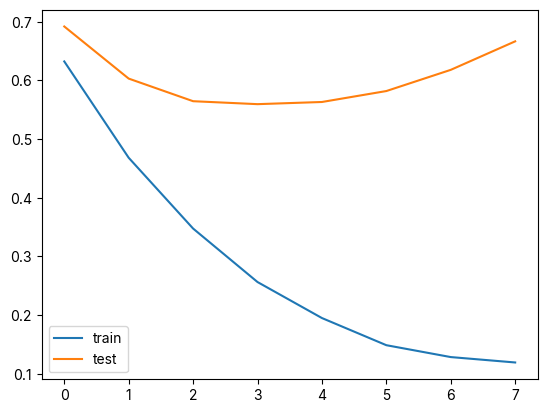

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_lossi, label="train")
ax.plot(test_lossi, label="test")
ax.legend()
plt.show()

Total Accuracy: 84.10%

Arabic    : 100.00%, 0.00%, 200  
Russian   : 96.06%, 2.13%, 939  
Japanese  : 92.00%, 2.00%, 100  
Greek     : 85.71%, 4.76%, 21   
English   : 79.56%, 13.35%, 367  
Italian   : 73.24%, 15.49%, 71   
Chinese   : 66.67%, 18.52%, 27   
German    : 63.01%, 20.55%, 73   
Dutch     : 53.33%, 16.67%, 30   
French    : 46.43%, 25.00%, 28   
Czech     : 40.38%, 23.08%, 52   
Polish    : 35.71%, 28.57%, 14   
Irish     : 29.17%, 25.00%, 24   
Vietnamese: 25.00%, 37.50%, 8    
Korean    : 20.00%, 30.00%, 10   
Spanish   : 16.67%, 26.67%, 30   
Portuguese: 12.50%, 37.50%, 8    
Scottish  : 0.00%, 30.00%, 10   


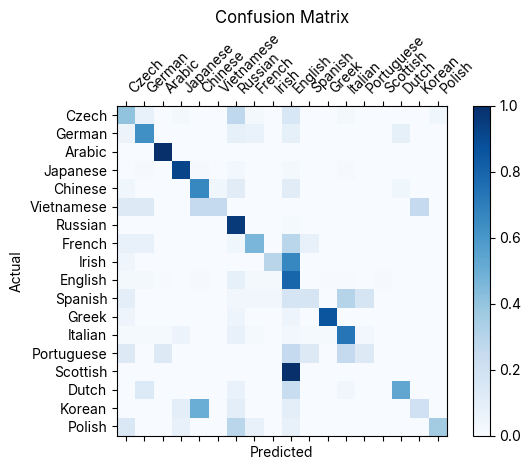

In [53]:
import numpy as np


@torch.inference_mode()
def classify(name):
    model.eval()
    x = torch.tensor([wtoi[ch] for ch in name], dtype=torch.long)
    x = x.unsqueeze(0)
    logits, _ = model(x, torch.tensor([len(name)], dtype=torch.long))
    probs = F.softmax(logits, dim=1)
    top2_probs, top2_indices = torch.topk(probs, 2, dim=1)
    model.train()
    return [(itolang[top2_indices[0][i].item()], top2_probs[0][i].item()) for i in range(2)]


def evaluate_language_accuracy(dataset):
    # Initialize confusion matrix and accuracy counters
    confusion_matrix = {lang: {l: [] for l in language_names} for lang in language_names}
    accuracy = {lang: 0 for lang in language_names}
    accuracy2 = {lang: 0 for lang in language_names}
    total = {lang: 0 for lang in language_names}

    # Evaluate each language
    for name, lang in test_data:
        predictions = classify(name)
        pred_lang, pred_prob = predictions[0]
        pred_lang2, pred_prob2 = predictions[1]

        confusion_matrix[lang][pred_lang].append(name)
        total[lang] += 1
        if pred_lang == lang:
            accuracy[lang] += 1
        if pred_lang2 == lang:
            accuracy2[lang] += 1

    # Calculate total accuracy
    total_correct = sum(accuracy.values())
    total_samples = sum(total.values())
    total_accuracy = total_correct / total_samples
    print(f"Total Accuracy: {total_accuracy:.2%}\n")

    # Create a list of tuples containing language, acc and acc2
    lang_acc = [(lang, accuracy[lang]/total[lang], accuracy2[lang]/total[lang]) for lang in language_names]
    # Sort the list by acc in descending order
    lang_acc.sort(key=lambda x: x[1], reverse=True)
    # Print the sorted results
    for lang, acc, acc2 in lang_acc:
        print(f"{lang:<10}: {acc:.2%}, {acc2:.2%}, {total[lang]:<5}")

    langs = list(language_names.keys())
    confusion_array = np.zeros((len(langs), len(langs)))
    for i, lang1 in enumerate(langs):
        for j, lang2 in enumerate(langs):
            confusion_array[i, j] = len(confusion_matrix[lang1][lang2])

    # Normalize confusion matrix
    row_sums = confusion_array.sum(axis=1, keepdims=True)
    confusion_array = np.divide(confusion_array, row_sums, where=row_sums != 0)

    # Plot confusion matrix
    fig, ax = plt.subplots()
    im = ax.matshow(confusion_array, cmap='Blues')
    plt.colorbar(im)

    # Set ticks and labels
    plt.xticks(range(len(langs)), langs, rotation=45, ha='left')
    plt.yticks(range(len(langs)), langs)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


# Run evaluation
evaluate_language_accuracy(test_data)